# Final Presentation Outline: Enhanced Emotional Speech Data Generation

## 1. Business Understanding

### Problem Statement
- **Challenge**: Emotion recognition in audio signals requires high-quality data with clear emotional characteristics
- **Current Issues**: Limited availability of high-quality emotional speech datasets
- **Solution Approach**: Use generative models to enhance emotional clarity in existing datasets

### Business Value
- Improved emotion recognition systems for call centers, virtual assistants, and healthcare applications
- Cost-effective generation of high-quality emotional speech data
- Enhanced emotional expressiveness in speech synthesis applications
- Data augmentation services for AI training

## 2. Data Understanding

### Datasets
- **EmoDB**: German emotional speech dataset
  - 10 speakers (5 male, 5 female)
  - Emotions: neutral, happy, sad, angry, fear, disgust
  - 16 kHz sampling rate
  - 454 total samples

- **RAVDESS**: English emotional speech dataset
  - 24 speakers (12 male, 12 female)
  - Emotions: neutral, happy, sad, angry, fear, disgust (plus calm, surprised in original)
  - 48 kHz sampling rate
  - 1056 total samples

### Data Exploration
- Distribution of emotions across datasets
- Mel-spectrogram visualizations for different emotions
- Audio sample analysis
- Correlation between audio features and emotions

## 3. Data Preparation

### Preprocessing Steps
- Resampling both datasets to 22,025 Hz
- Padding all samples to 10 seconds length
- Converting audio to mel-spectrograms using STFT
  - Window size: 1024
  - Hop length: 256
  - Number of mel bands: 80
- Z-score normalization of mel-spectrograms
- Train/test split (80%/20%)


In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nesrinelouati_data_voice_path = kagglehub.dataset_download('nesrinelouati/data-voice')
#khaledbnahmed_datasetemo_path = kagglehub.dataset_download('khaledbnahmed/datasetemo')

print('Data source import complete.')


Data source import complete.


## 📦 Cell 1: Imports and Global Constants
This cell includes all necessary Python packages for data loading, processing, and visualization. It also defines global constants for spectrogram computation and sets up the device (GPU/CPU).


In [ ]:
# =========================================================
# Cell 1: Imports & Global Constants
# =========================================================

# -- System & Utilities --
import os, math, random, pathlib, shutil, json, warnings, gc

# -- Data Science & Visualization --
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
from IPython.display import display, Audio

# -- PyTorch & Audio --
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from torchvision import models

# -- Dataset --
from dataset import EmotionalSpeechDataset

# -- Evaluation Metrics --
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# -- Global Constants (Match Paper) --
SR            = 22025           # resample to 22 025 Hz
MAX_SECS      = 10              # pad / truncate to 10 s
N_FFT         = 1024
HOP           = 256
N_MELS        = 80
MEL_WIDTH     = math.ceil(SR * MAX_SECS / HOP)  # ≈ 861

# -- Device Setup --
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
warnings.filterwarnings("ignore")


## 📦 Cell 2: DATA PREPARATION - EmotionalSpeechDataset

> Ajouter une citation


This cell defines the `EmotionalSpeechDataset` class, a custom dataset for loading and processing speech data. It handles loading audio files, computing Mel spectrograms, padding/truncating audio to a fixed length, and transforming the data as required.
Data Preprocessing (Section 4.1):

- ✅ Resampling both datasets to 22,025 Hz
- ✅ Adjusting length to 10 seconds with padding
- ✅ Using STFT with window size 1024 and hop length 256
- ✅ Creating mel-spectrograms
- ✅ Applying Z-score normalization

In [ ]:
dataset_code = """
import torchaudio
import torch
import pathlib
import torch.nn.functional as F
from torch.utils.data import Dataset

SR = 16000
N_FFT = 1024
HOP = 256
N_MELS = 80
MAX_SECS = 10

class EmotionalSpeechDataset(Dataset):
    def __init__(self, root_dir, dataset_name, emotions, transform=None):
        self.root_dir     = pathlib.Path(root_dir)
        self.dataset_name = dataset_name
        self.emotions     = emotions
        self.transform    = transform
        self.samples      = self._scan()

        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, power=2.0
        )
        self.to_db = torchaudio.transforms.AmplitudeToDB()

    def _scan(self):
        out = []
        if self.dataset_name.lower() == "emodb":
            mapping = dict(W='anger', L='boredom', E='disgust', A='fear',
                           F='happiness', T='sadness', N='neutral')
            for wav in self.root_dir.glob("*.wav"):
                emo = mapping.get(wav.name[5])
                if emo in self.emotions:
                    out.append((wav, self.emotions.index(emo)))
        elif self.dataset_name.lower() == "ravdess":
            mapping = {
                f"{i:02d}": e for i, e in enumerate(
                    ['neutral','calm','happiness','sadness','anger','fear','disgust','surprise'], 1)
            }
            for wav in self.root_dir.rglob("*.wav"):
                try:
                    emo_code = wav.name.split('-')[2]
                    emo = mapping.get(emo_code)
                    if emo in self.emotions:
                        out.append((wav, self.emotions.index(emo)))
                except Exception as e:
                    print(f"Skipping {wav.name}: {e}")
                if emo in self.emotions:
                    out.append((wav, self.emotions.index(emo)))
        return out

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, emo_idx = self.samples[idx]
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        if sr != SR:
            wav = torchaudio.transforms.Resample(sr, SR)(wav)

        target_len = SR * MAX_SECS
        if wav.shape[1] < target_len:
            wav = F.pad(wav, (0, target_len - wav.shape[1]))
        else:
            wav = wav[:, :target_len]

        mel = self.to_db(self.mel(wav))
        mel = (mel - mel.mean()) / (mel.std() + 1e-8)

        if self.transform:
            mel = self.transform(mel)

        return {
            "waveform": wav,
            "mel_spectrogram": mel,
            "emotion": emo_idx,
            "path": str(path),
        }
"""

# Write it to file
with open("dataset.py", "w") as f:
    f.write(dataset_code)


## 📊 Cell 3: Visualize Emotion Spectrograms
This cell visualizes mel-spectrograms and waveforms for different emotions from the dataset. It will randomly select one sample per emotion, display its mel-spectrogram, waveform, and allow for audio playback.

---

## 🎧 Cell 4: Visualize Enhanced Emotions (Original vs Enhanced)
This cell compares the original and enhanced mel-spectrograms for selected emotions. It visualizes them side by side and also plays the corresponding audio samples for each emotion, allowing for comparison between the original and enhanced versions.





In [ ]:
def visualize_emotion_spectrograms(dataset, emotions, num_examples=1, figsize=(18, 15)):
    """
    Visualize mel-spectrograms from the dataset, one example per emotion class.

    Args:
        dataset: Dataset containing mel-spectrograms and emotion labels
        emotions: List of emotion names corresponding to label indices
        num_examples: Number of examples to show per emotion class
        figsize: Figure size for the visualization
    """


    # Find one example from each emotion class
    examples_by_emotion = {}

    # Create a dictionary to store indices for each emotion
    indices_by_emotion = {i: [] for i in range(len(emotions))}

    # Go through dataset and organize indices by emotion
    for idx in range(len(dataset)):
        try:
            sample = dataset[idx]
            emotion_idx = sample['emotion'] if isinstance(sample['emotion'], int) else sample['emotion'].item()
            indices_by_emotion[emotion_idx].append(idx)
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            continue

    # Calculate grid dimensions
    rows = len(emotions)
    cols = 2  # Mel-spectrogram and waveform

    # Create figure
    plt.figure(figsize=figsize)

    # Loop through each emotion
    for i, emotion in enumerate(emotions):
        if i >= len(indices_by_emotion) or not indices_by_emotion[i]:
            print(f"No examples found for emotion: {emotion}")
            continue

        # Get sample indices for this emotion
        emotion_indices = indices_by_emotion[i]

        # If no samples found for this emotion, skip
        if not emotion_indices:
            print(f"No examples found for emotion: {emotion}")
            continue

        # Select a random example if there are multiple
        selected_idx = np.random.choice(emotion_indices)
        sample = dataset[selected_idx]

        # Get mel-spectrogram
        mel = sample['mel_spectrogram']
        if isinstance(mel, torch.Tensor):
            mel = mel.cpu().numpy()

        # Get waveform if available
        waveform = sample.get('waveform')
        if waveform is not None and isinstance(waveform, torch.Tensor):
            waveform = waveform.cpu().numpy()

        # Ensure mel is 2D (remove batch and channel dims if present)
        if mel.ndim > 2:
            mel = np.squeeze(mel)

        # Plot mel-spectrogram
        plt.subplot(rows, cols, i*cols + 1)
        librosa.display.specshow(
            mel,
            sr=22025,  # Sampling rate from the paper
            hop_length=256,  # Hop length from the paper
            x_axis='time',
            y_axis='mel'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{emotion} - Mel-Spectrogram")

        # Plot waveform if available
        if waveform is not None:
            plt.subplot(rows, cols, i*cols + 2)
            if waveform.ndim > 1:
                waveform = np.squeeze(waveform)
            plt.plot(waveform)
            plt.title(f"{emotion} - Waveform")
            plt.xlim(0, len(waveform))
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('emotion_mel_spectrograms.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create a second figure with audio playback
    print("\nAudio samples for each emotion:")
    for i, emotion in enumerate(emotions):
        if i >= len(indices_by_emotion) or not indices_by_emotion[i]:
            continue

        # Get sample for this emotion
        selected_idx = np.random.choice(indices_by_emotion[i])
        sample = dataset[selected_idx]

        # Get waveform
        waveform = sample.get('waveform')
        if waveform is not None:
            if isinstance(waveform, torch.Tensor):
                waveform = waveform.cpu().numpy()
            if waveform.ndim > 1:
                waveform = np.squeeze(waveform)

            print(f"\n{emotion} audio sample:")
            # Create audio widget with the correct sample rate
            display(Audio(waveform, rate=22025))

# Usage example:
# visualize_emotion_spectrograms(train_ds, emotions=["neutral", "happiness", "sadness", "anger", "fear", "disgust"])


def visualize_enhanced_emotions(original_mels, enhanced_mels, emotions, indices, sr=22025, hop_length=256):
    """
    Visualize original and enhanced mel-spectrograms side by side for specific emotion indices.

    Args:
        original_mels: Dictionary or list of original mel-spectrograms
        enhanced_mels: Dictionary or list of enhanced mel-spectrograms
        emotions: List of emotion names
        indices: List of emotion indices to visualize
        sr: Sampling rate
        hop_length: Hop length for spectrogram conversion
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import librosa.display
    import torch
    from IPython.display import display, Audio

    # Calculate grid dimensions
    rows = len(indices)
    cols = 2  # Original and enhanced

    # Create figure
    plt.figure(figsize=(16, 4 * rows))

    for i, emotion_idx in enumerate(indices):
        emotion_name = emotions[emotion_idx]

        # Get original mel
        if isinstance(original_mels, dict):
            orig_mel = original_mels[emotion_idx]
        else:
            orig_mel = original_mels[i]

        # Get enhanced mel
        if isinstance(enhanced_mels, dict):
            enh_mel = enhanced_mels[emotion_idx]
        else:
            enh_mel = enhanced_mels[i]

        # Convert to numpy if tensors
        if isinstance(orig_mel, torch.Tensor):
            orig_mel = orig_mel.cpu().numpy()
        if isinstance(enh_mel, torch.Tensor):
            enh_mel = enh_mel.cpu().numpy()

        # Ensure 2D
        if orig_mel.ndim > 2:
            orig_mel = np.squeeze(orig_mel)
        if enh_mel.ndim > 2:
            enh_mel = np.squeeze(enh_mel)

        # Plot original
        plt.subplot(rows, cols, i*cols + 1)
        librosa.display.specshow(
            orig_mel,
            sr=sr,
            hop_length=hop_length,
            x_axis='time',
            y_axis='mel'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Original {emotion_name}")

        # Plot enhanced
        plt.subplot(rows, cols, i*cols + 2)
        librosa.display.specshow(
            enh_mel,
            sr=sr,
            hop_length=hop_length,
            x_axis='time',
            y_axis='mel'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Enhanced {emotion_name}")

    plt.tight_layout()
    plt.savefig('enhanced_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create audio samples
    print("\nAudio comparison of original vs enhanced for each emotion:")
    for i, emotion_idx in enumerate(indices):
        emotion_name = emotions[emotion_idx]

        # Get mels
        if isinstance(original_mels, dict):
            orig_mel = original_mels[emotion_idx]
        else:
            orig_mel = original_mels[i]

        if isinstance(enhanced_mels, dict):
            enh_mel = enhanced_mels[emotion_idx]
        else:
            enh_mel = enhanced_mels[i]

        # Convert to numpy if tensors
        if isinstance(orig_mel, torch.Tensor):
            orig_mel = orig_mel.cpu().numpy()
        if isinstance(enh_mel, torch.Tensor):
            enh_mel = enh_mel.cpu().numpy()

        # Ensure 2D
        if orig_mel.ndim > 2:
            orig_mel = np.squeeze(orig_mel)
        if enh_mel.ndim > 2:
            enh_mel = np.squeeze(enh_mel)

        # Convert to audio
        orig_audio = librosa.feature.inverse.mel_to_audio(orig_mel, sr=sr, hop_length=hop_length)
        enh_audio = librosa.feature.inverse.mel_to_audio(enh_mel, sr=sr, hop_length=hop_length)

        # Display audio
        print(f"\n{emotion_name} - Original:")
        display(Audio(orig_audio, rate=sr))

        print(f"{emotion_name} - Enhanced:")
        display(Audio(enh_audio, rate=sr))


In [ ]:
def visualize_dataset(train_ds, test_ds, emotions):
    """
    Visualize the distribution of emotions in the datasets
    """
    print("Analyzing dataset distribution...")

    # Count emotions in training set
    train_emotions = []
    for i in range(len(train_ds)):
        try:
            sample = train_ds[i]
            train_emotions.append(sample['emotion'])
        except:
            pass

    # Count emotions in test set
    test_emotions = []
    for i in range(len(test_ds)):
        try:
            sample = test_ds[i]
            test_emotions.append(sample['emotion'])
        except:
            pass

    # Convert to numpy arrays for counting
    train_emotions = np.array(train_emotions)
    test_emotions = np.array(test_emotions)

    # Create counts
    train_counts = [np.sum(train_emotions == i) for i in range(len(emotions))]
    test_counts = [np.sum(test_emotions == i) for i in range(len(emotions))]

    # Plot emotion distribution
    plt.figure(figsize=(12, 10))

    # Training set distribution
    plt.subplot(2, 1, 1)
    bars = plt.bar(emotions, train_counts, color='skyblue')
    plt.title('Emotion Distribution in Training Set', fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on top of bars
    for bar, count in zip(bars, train_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 str(count), ha='center', fontsize=10)

    # Test set distribution
    plt.subplot(2, 1, 2)
    bars = plt.bar(emotions, test_counts, color='salmon')
    plt.title('Emotion Distribution in Test Set', fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on top of bars
    for bar, count in zip(bars, test_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 str(count), ha='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('emotion_distribution.png')
    plt.show()

    # Visualize sample mel-spectrograms for each emotion
    plt.figure(figsize=(15, 10))

    # Get one example of each emotion from training set
    for i, emotion in enumerate(emotions):
        emotion_idx = emotions.index(emotion)
        # Find samples with this emotion
        samples = [j for j in range(len(train_ds)) if
                   train_ds[j]['emotion'] == emotion_idx]

        if samples:
            # Get a sample
            sample_idx = samples[0]
            mel = train_ds[sample_idx]['mel_spectrogram']

            # Plot
            plt.subplot(2, 3, i+1)
            if isinstance(mel, torch.Tensor):
                mel = mel.squeeze().cpu().numpy()
            librosa.display.specshow(
                mel, sr=SR, hop_length=TRIM_HOP_LENGTH if SMALLER_MODEL else HOP,
                y_axis='mel', x_axis='time'
            )
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Mel-Spectrogram: {emotion}')

    plt.tight_layout()
    plt.savefig('emotion_spectrograms.png')
    plt.show()

In [ ]:
def evaluate_emotion_recognition(model, dataloader, device):
    """Evaluate the emotion recognition model."""
    model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            mel_spectrograms = batch['mel_spectrogram'].to(device)
            labels = batch['emotion']

            outputs = model(mel_spectrograms)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'labels': all_labels
    }

In [ ]:

def plot_mel(mel, title=None):
    if isinstance(mel, torch.Tensor):
        mel = mel.squeeze().cpu().numpy()
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        mel, sr=SR, hop_length=HOP,
        y_axis='mel', x_axis='time'
    )
    plt.colorbar(format='%+2.0f dB')
    if title: plt.title(title)
    plt.tight_layout(); plt.show()


# Modeling ✅
## 1. EmotionRecognitionModel

- ✅ Using ResNet-50 as the backbone (as mentioned in Section 4.2)
- ✅ Modifying the first conv layer to accept single-channel mel-spectrograms (1 channel)
- ✅ Providing an embedding output (256-dimensional) for emotion representation
- ✅ Allowing dual output mode: classification logits or (logits, embedding)



In [ ]:
class EmotionRecognitionModel(nn.Module):
    def __init__(self, num_emotions: int):
        super().__init__()
        self.backbone = models.resnet50(weights=None)   # paper trains from scratch
        self.backbone.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(dim, num_emotions)
        self.embedding   = nn.Linear(dim, 256)

    def forward(self, x, return_embedding=False):
        # manually unroll forward until avgpool
        x = self.backbone.conv1(x); x = self.backbone.bn1(x)
        x = self.backbone.relu(x); x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x); x = self.backbone.layer2(x)
        x = self.backbone.layer3(x); x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)
        feats = torch.flatten(x, 1)        # (B, dim)

        if return_embedding:
            return self.backbone.fc(feats), self.embedding(feats)
        return self.backbone.fc(feats)


## 2. Diffusion Model
1. Layer Structure:

    - ✅ Initial input layer: (32, 80, 861) → (32, 256, 861)
    - ✅ ResNet block: (32, 256, 861) → (32, 256, 861) with stride 1
    - ✅ Downsample: (32, 256, 861) → (32, 512, 430) with stride 2
    - ✅ ResNet block: (32, 512, 430) → (32, 1024, 215)
    - ✅ Upsample: (32, 1024, 215) → (32, 512, 430) with stride 2
    - ✅ ResNet block: (32, 512, 430) → (32, 256, 861)
    - ✅ Final Conv2d: (32, 256, 861) → (32, 1, 861) with stride 1


2. Additional Components:

    - ✅ ResNet blocks with time embeddings (as shown in Figure 2)
    - ✅ Attention mechanism in ResNet blocks (mentioned in Section 4.3)
    - ✅ Emotion embedding integration (as described in Section 4.3)
    - ✅ Sinusoidal position embeddings for temporal information

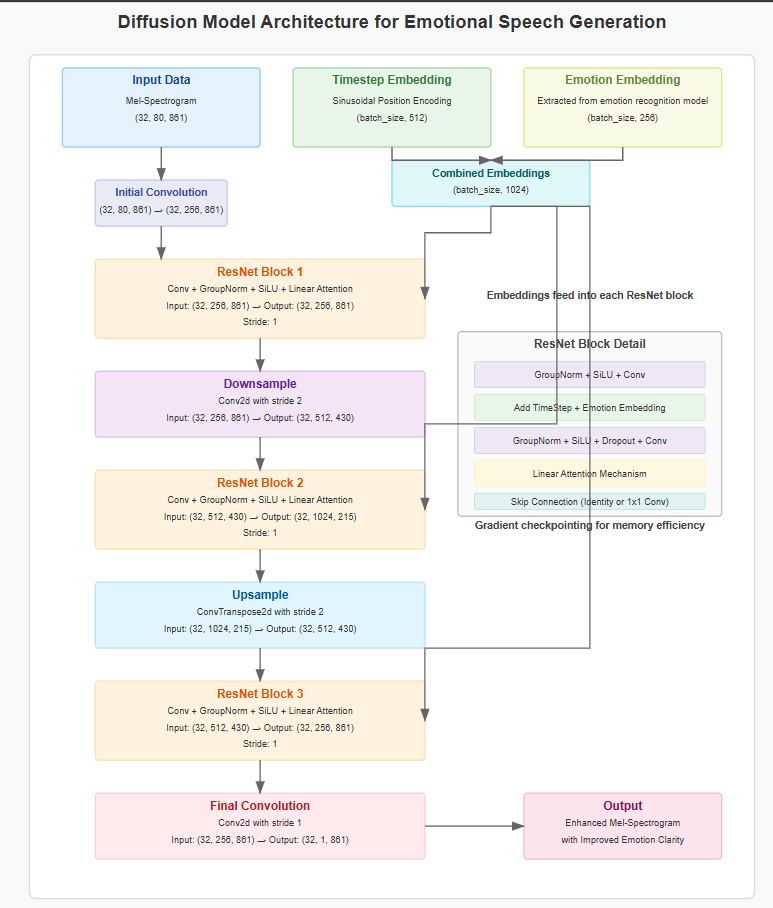

In [ ]:


# Attention Block as mentioned in the paper
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-2:]
        x = x.flatten(2).transpose(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.transpose(1, 2).view(-1, self.channels, *size)


# ResNet Block with gradient checkpointing
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels=512, use_attn=False, dropout=0.1):
        super(ResnetBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.use_attn = use_attn

        # Enable gradient checkpointing to save memory
        self.use_checkpoint = True

        self.norm1 = nn.GroupNorm(32, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)

        # Time embedding projection
        self.temb_proj = nn.Linear(temb_channels, out_channels)

        self.norm2 = nn.GroupNorm(32, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        if self.in_channels != self.out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

        # Add attention block only if use_attn is True
        if use_attn:
            self.attn = AttentionBlock(out_channels)

    def forward(self, x, temb):
        # Use gradient checkpointing to save memory
        if self.use_checkpoint and x.requires_grad:
            return torch.utils.checkpoint.checkpoint(
                self._forward, x, temb
            )
        else:
            return self._forward(x, temb)

    def _forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = F.silu(h)
        h = self.conv1(h)

        # Add time embedding
        temb = self.temb_proj(F.silu(temb))[:, :, None, None]
        h = h + temb

        h = self.norm2(h)
        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        # Apply attention only if use_attn is True
        if self.use_attn:
            h = self.attn(h)

        return h + self.shortcut(x)

# Sinusoidal position embedding
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal timestep embeddings like in the original DDPM paper.
    """
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

    if embedding_dim % 2 == 1:  # zero pad if embedding_dim is odd
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))

    return emb

# Complete Diffusion Model matching Table 4
class DiffusionModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=512, emotion_emb_dim=256):
        super(DiffusionModel, self).__init__()

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Emotion embedding projection
        self.emotion_embed = nn.Sequential(
            nn.Linear(emotion_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Initial projection (32, 80, 861) -> (32, 256, 861)
        self.init_conv = nn.Conv2d(in_channels, 256, 3, padding=1)

        # ResNet block (32, 256, 861) stride 1 -> (32, 256, 861)
        self.resnet_block1 = ResnetBlock(256, 256, time_emb_dim * 2)

        # Downsample (32, 256, 861) stride 2 -> (32, 512, 430)
        self.downsample = nn.Conv2d(256, 512, 4, stride=2, padding=1)

        # ResNet block (32, 512, 430) stride 1 -> (32, 1024, 215)
        self.resnet_block2 = ResnetBlock(512, 1024, time_emb_dim * 2)

        # Upsample (32, 1024, 215) stride 2 -> (32, 512, 430)
        self.upsample = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)

        # ResNet block (32, 512, 430) stride 1 -> (32, 256, 861)
        self.resnet_block3 = ResnetBlock(512, 256, time_emb_dim * 2)

        # Final Conv2d (32, 256, 861) stride 1 -> (32, 1, 861)
        self.final_conv = nn.Conv2d(256, out_channels, 3, stride=1, padding=1)

    def forward(self, x, timesteps, emotion_embedding):
        # Time embedding
        t_emb = get_timestep_embedding(timesteps, 512)
        t_emb = self.time_embed(t_emb)

        # Emotion embedding
        e_emb = self.emotion_embed(emotion_embedding)

        # Combine time and emotion embeddings
        temb = torch.cat([t_emb, e_emb], dim=1)

        # Initial convolution
        h = self.init_conv(x)  # (32, 256, 861)

        # ResNet block 1
        h = self.resnet_block1(h, temb)  # (32, 256, 861)

        # Downsample
        h = self.downsample(h)  # (32, 512, 430)

        # ResNet block 2
        h = self.resnet_block2(h, temb)  # (32, 1024, 215)

        # Upsample
        h = self.upsample(h)  # (32, 512, 430)

        # ResNet block 3
        h = self.resnet_block3(h, temb)  # (32, 256, 861)

        # Final convolution
        output = self.final_conv(h)  # (32, 1, 861)

        # Ensure output has same size as input along the time dimension
        if output.shape[-1] != x.shape[-1]:
            output = F.pad(output, (0, x.shape[-1] - output.shape[-1]))

        return output

#  Training functions SER
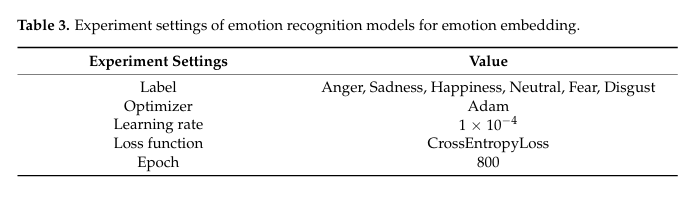
1. **Optimizer**:
   - ✅ Uses Adam optimizer with learning rate 1e-4, exactly as specified in the paper: "Adam was used as the optimization function, the learning rate was set to 1×10^-4"

2. **Loss Function**:
   - ✅ Uses CrossEntropyLoss, matching the paper: "the CrossEntropyLoss function was used as the loss function"

3. **Training Process**:
   - ✅ Implements a standard training loop with gradient calculation, optimization step, and accuracy tracking
   - ✅ The paper mentions 800 epochs, but your function defaults to 15 epochs (though this can be adjusted when calling the function)

4. **Metrics Tracking**:
   - ✅ Tracks both loss and accuracy metrics, which would allow you to evaluate model performance


In [ ]:
# =========================================================
# Cell 8 : training functions  (SER + Diffusion)
# =========================================================
def train_ser(model, loader, *, epochs=10, log_every=1):
    """
    Train the speech‑emotion recogniser.

    Args
    ----
    model      : EmotionRecognitionModel
    loader     : DataLoader
    epochs     : int
    log_every  : print every N epochs
    """
    model.to(DEVICE).train()
    opt  = torch.optim.Adam(model.parameters(), lr=1e-4)
    crit = nn.CrossEntropyLoss()

    for ep in range(epochs):
        loss_sum = correct = total = 0
        pbar = tqdm(loader, desc=f"[SER] epoch {ep+1}/{epochs}", leave=False)
        for batch in pbar:
            mel = batch["mel_spectrogram"].to(DEVICE)
            lab = batch["emotion"].to(DEVICE)

            opt.zero_grad()
            out  = model(mel)
            loss = crit(out, lab)
            loss.backward(); opt.step()

            loss_sum += loss.item()
            pred = out.argmax(1)
            correct += (pred == lab).sum().item()
            total   += lab.size(0)

            pbar.set_postfix(
                loss=f"{loss_sum / (total // lab.size(0) + 1):.4f}",
                acc =f"{correct / total:.3%}"
            )

        # epoch summary
        if (ep + 1) % log_every == 0:
            print(f"[SER] ep {ep+1:>3}/{epochs}  "
                  f"loss {loss_sum/len(loader):.4f}  "
                  f"acc {correct/total:.3%}")




# Training functions Diffusion

1. **Memory Optimization**:
   - ✅ Implements several memory optimization techniques mentioned in the paper: "To solve the memory problem in training the model, we used mel-spectrogram resizing and a batch-based training process"
   - ✅ Uses sub-batching, mixed precision training, and periodic cache clearing to optimize memory usage
   - ✅ Explicitly deletes intermediate variables to free memory

2. **Emotion Embedding Integration**:
   - ✅ Uses emotion embeddings from the pretrained emotion model as conditional input to the diffusion model
   - ✅ Freezes the emotion model during diffusion training, which is appropriate since it's used for embedding extraction

3. **Training Process**:
   - ✅ Uses the diffusion sampler's `p_losses` method to calculate the diffusion model loss
   - ✅ Implements a full training loop with gradient calculation, optimization step, and loss tracking

4. **Advanced Features**:
   - ✅ Implements early stopping for better convergence
   - ✅ Uses TensorBoard logging for monitoring training progress
   - ✅ Saves checkpoints periodically and best model based on loss
   - ✅ Uses mixed precision training for better performance


In [ ]:
# Optimized training function
def train_diffusion(model, sampler, emotion_model, dataloader, epochs, lr=1e-4,
                   save_dir="./checkpoints", log_dir="./runs", device="cuda",
                   checkpoint_every=5, early_stop_patience=5):
    """
    Train the diffusion model with memory optimizations

    Args:
        model: The diffusion model
        sampler: The diffusion sampler
        emotion_model: The emotion recognition model (frozen)
        dataloader: DataLoader for training data
        epochs: Number of training epochs
        lr: Learning rate
        save_dir: Directory to save checkpoints
        log_dir: Directory for tensorboard logs
        device: Device to train on
        checkpoint_every: Save checkpoint every n epochs
        early_stop_patience: Early stopping patience
    """
    import os
    from torch.utils.tensorboard import SummaryWriter

    # Create directories if they don't exist
    os.makedirs(save_dir, exist_ok=True)

    # Set up tensorboard writer
    writer = SummaryWriter(log_dir)

    # Set up optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Set up mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # Set up early stopping
    best_loss = float('inf')
    patience_counter = 0

    # Set emotion model to eval mode (frozen)
    emotion_model.eval()

    # Calculate maximum batch size based on GPU memory
    max_batch_size = 8  # Conservative default, can be adjusted

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, batch in enumerate(progress_bar):
            # Clear cache periodically
            if torch.cuda.is_available() and batch_idx % 5 == 0:
                torch.cuda.empty_cache()

            # Process in smaller sub-batches if needed
            full_batch_size = len(batch['mel_spectrogram'])
            for sub_batch_start in range(0, full_batch_size, max_batch_size):
                sub_batch_end = min(sub_batch_start + max_batch_size, full_batch_size)
                sub_batch_size = sub_batch_end - sub_batch_start

                # Get sub-batch data
                mel_spectrograms = batch['mel_spectrogram'][sub_batch_start:sub_batch_end].to(device)
                emotions = batch['emotion'][sub_batch_start:sub_batch_end].to(device)

                # Extract emotion embeddings (no gradients needed)
                with torch.no_grad():
                    _, emotion_embeddings = emotion_model(mel_spectrograms, return_embedding=True)

                # Sample random timesteps
                t = torch.randint(0, sampler.timesteps, (sub_batch_size,), device=device).long()

                # Use mixed precision
                with torch.cuda.amp.autocast():
                    loss = sampler.p_losses(mel_spectrograms, t, emotion_embeddings)

                # Backward and optimize with gradient scaling
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                # Update metrics
                epoch_loss += loss.item()
                batch_count += 1

                # Explicitly delete intermediate variables to free memory
                del mel_spectrograms, emotions, emotion_embeddings, t, loss

            # Update progress bar
            avg_loss = epoch_loss / batch_count
            progress_bar.set_postfix({"loss": avg_loss})

        # Log to tensorboard
        avg_epoch_loss = epoch_loss / batch_count
        writer.add_scalar('Loss/train', avg_epoch_loss, epoch)

        # Save checkpoint
        if (epoch + 1) % checkpoint_every == 0:
            checkpoint_path = os.path.join(save_dir, f"diffusion_model_epoch_{epoch+1}.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_epoch_loss,
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")

        # Early stopping
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            patience_counter = 0
            # Save best model
            best_model_path = os.path.join(save_dir, "diffusion_model_best.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, best_model_path)
            print(f"New best model saved with loss: {best_loss:.6f}")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Close tensorboard writer
    writer.close()

    print(f"Training completed. Best loss: {best_loss:.6f}")

In [ ]:
def linear_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T)



1. **Beta Schedule & Diffusion Parameters**:
   - ✅ Implements the linear beta schedule for controlled noise addition
   - ✅ Calculates all necessary diffusion parameters (alphas, posterior variance, etc.)
   - ✅ Follows the DDPM (Denoised Diffusion Probabilistic Model) approach referenced in the paper

2. **Forward Diffusion Process (`q_sample`)**:
   - ✅ Correctly implements the forward process of adding noise according to the time step
   - ✅ Maintains the statistical properties described in the diffusion literature

3. **Loss Calculation (`p_losses`)**:
   - ✅ Implements the simple MSE loss between predicted and actual noise
   - ✅ Includes memory optimization by explicitly deleting intermediate tensors

4. **Emotion Enhancement (`enhance_emotion`)**:
   - ✅ Uses the emotion recognition model to get emotion embeddings
   - ✅ Creates a speech activity mask to focus enhancement on spoken regions
   - ✅ Implements a controlled partial diffusion + denoising approach



In [ ]:
class DiffusionSampler:
    def __init__(self, diffusion_model, emotion_model, timesteps=200):
        """
        Args:
            diffusion_model: The noise prediction model
            emotion_model: The emotion recognition model for emotion embeddings
            timesteps: Number of diffusion steps
        """
        self.diffusion_model = diffusion_model
        self.emotion_model = emotion_model
        self.timesteps = timesteps

        # Define beta schedule (linear)
        self.betas = self._linear_beta_schedule(timesteps)

        # Define alphas
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]])

        # Calculations for diffusion q(x_t | x_{t-1}) and posterior q(x_{t-1} | x_t, x_0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_log_variance_clipped = torch.log(torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]]))
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def _linear_beta_schedule(self, timesteps, start=1e-4, end=0.02):
        """Linear beta schedule."""
        return torch.linspace(start, end, timesteps)

    def to(self, device):
        """Move all tensors to device."""
        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alphas_cumprod = self.alphas_cumprod.to(device)
        self.alphas_cumprod_prev = self.alphas_cumprod_prev.to(device)
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(device)
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(device)
        self.posterior_variance = self.posterior_variance.to(device)
        self.posterior_log_variance_clipped = self.posterior_log_variance_clipped.to(device)
        self.posterior_mean_coef1 = self.posterior_mean_coef1.to(device)
        self.posterior_mean_coef2 = self.posterior_mean_coef2.to(device)
        return self

    def q_sample(self, x_0, t, noise=None):
        """
        Forward diffusion process: q(x_t | x_0)
        Add noise to x_0 according to timestep t
        """
        if noise is None:
            noise = torch.randn_like(x_0)

        # Extract correct alpha values for the batch
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

        # Apply diffusion
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        return x_t, noise

    def p_losses(self, x_0, t, emotion_embedding, noise=None):
        """
        Calculate the loss for training the diffusion model with memory optimization
        """
        if noise is None:
            noise = torch.randn_like(x_0)

        # Get noisy sample at timestep t
        x_noisy, _ = self.q_sample(x_0, t, noise)

        # Predict the noise with the model
        predicted_noise = self.diffusion_model(x_noisy, t, emotion_embedding)

        # Calculate loss (typical MSE loss)
        loss = F.mse_loss(predicted_noise, noise)

        # Explicitly delete intermediate tensors to free memory
        del x_noisy, predicted_noise

        return loss

    def enhance_emotion(self, mel_spectrogram, emotion_idx, steps=50):
        """
        Enhance the emotion in a mel-spectrogram using the diffusion model
        """
        self.diffusion_model.eval()
        self.emotion_model.eval()

        with torch.no_grad():
            # Process input dimensions to ensure proper shape
            original_shape = mel_spectrogram.shape

            # Ensure 4D input: [batch, channel, height, width]
            if len(original_shape) == 2:  # [height, width]
                mel_spectrogram = mel_spectrogram.unsqueeze(0).unsqueeze(0)
            elif len(original_shape) == 3:  # [channel, height, width] or [batch, height, width]
                if original_shape[0] == 80:  # Likely mel bands dimension
                    mel_spectrogram = mel_spectrogram.unsqueeze(0)
                else:
                    mel_spectrogram = mel_spectrogram.unsqueeze(1)
            elif len(original_shape) > 4:  # Extra dimensions
                mel_spectrogram = mel_spectrogram.squeeze()
                if len(mel_spectrogram.shape) == 2:
                    mel_spectrogram = mel_spectrogram.unsqueeze(0).unsqueeze(0)
                elif len(mel_spectrogram.shape) == 3:
                    mel_spectrogram = mel_spectrogram.unsqueeze(0)

            # Get emotion embedding
            _, emotion_emb = self.emotion_model(mel_spectrogram, return_embedding=True)

            # Create speech activity mask focused on the first 3 seconds
            # Values below threshold are considered silence
            silence_threshold = -3.0  # Can be adjusted based on mel-spectrogram values
            speech_mask = (mel_spectrogram > silence_threshold).float()

            # Focus on first 3 seconds (calculate frame index for 3 seconds)
            time_index_3sec = int(3 * 22025 / 256)  # 3 seconds in frames (depends on hop_length)
            if mel_spectrogram.shape[-1] > time_index_3sec:
                # Create temporal mask for first 3 seconds
                temporal_mask = torch.zeros_like(speech_mask)
                temporal_mask[..., :time_index_3sec] = 1.0

                # Apply temporal constraint to speech mask
                speech_mask = speech_mask * temporal_mask

            # Apply smoothing at speech boundaries
            if len(speech_mask.shape) == 4:  # Ensure proper dimensions for conv2d
                kernel_size = 5
                smoothing_kernel = torch.ones(1, 1, 1, kernel_size) / kernel_size
                smoothing_kernel = smoothing_kernel.to(mel_spectrogram.device)
                # Use proper 4D input
                speech_mask = F.conv2d(
                    speech_mask,
                    smoothing_kernel,
                    padding=(0, kernel_size//2)
                )
                speech_mask = torch.clamp(speech_mask, 0, 1)

            # Start with noisy mel-spectrogram (apply half diffusion)
            t_start = min(self.timesteps // 2, steps)
            t_batch = torch.full((1,), t_start, device=mel_spectrogram.device, dtype=torch.long)

            # Only add noise to speech regions
            noise = torch.randn_like(mel_spectrogram)
            masked_noise = noise * speech_mask

            # Apply controlled forward diffusion
            x_noisy, _ = self.q_sample(mel_spectrogram, t_batch, masked_noise)

            # Perform denoising diffusion from t_start to 0
            for t in range(t_start-1, -1, -1):
                # Clear cache periodically to save memory
                if t % 10 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()

                t_batch = torch.full((1,), t, device=mel_spectrogram.device, dtype=torch.long)

                # Predict noise
                predicted_noise = self.diffusion_model(x_noisy, t_batch, emotion_emb)

                # Apply mask to predicted noise (only denoise speech regions)
                predicted_noise = predicted_noise * speech_mask

                # Apply denoising step
                if t > 0:
                    # Add some noise for stochasticity (only to speech regions)
                    noise = torch.randn_like(x_noisy) * speech_mask
                    noise_strength = torch.sqrt(self.posterior_variance[t].view(-1, 1, 1, 1))
                    x_noisy = x_noisy - predicted_noise * noise_strength + noise * noise_strength
                else:
                    # Final step, no added noise
                    x_noisy = x_noisy - predicted_noise

            # Use the speech mask to blend enhanced regions with original silent regions
            enhanced = x_noisy
            result = enhanced * speech_mask + mel_spectrogram * (1 - speech_mask)

            # Return with original dimensions if needed
            if len(original_shape) <= 3:
                return result.squeeze(0)
            return result

In [ ]:
import multiprocessing as mp
if mp.get_start_method(allow_none=True) != 'spawn':
    mp.set_start_method('spawn', force=True)


In [ ]:
import os
print("EmoDB files:", os.listdir("/kaggle/input/data-voice/EmoDB/wav")[:5])
print("RAVDESS files:", os.listdir("/kaggle/input/data-voice/RAVDESS")[:5])


EmoDB files: ['15a04Fd.wav', '13b02Fb.wav', '09b01Wb.wav', '15a01Wa.wav', '14a05Wa.wav']
RAVDESS files: ['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21']


## Load data + EDA

In [ ]:
import os
from torch.utils.data import DataLoader

emotions = ['neutral','happiness','sadness','anger','fear','disgust']
emodb_ds = EmotionalSpeechDataset("/kaggle/input/data-voice/EmoDB/wav", "emodb", emotions)
rav_ds   = EmotionalSpeechDataset("/kaggle/input/data-voice/RAVDESS", "ravdess", emotions)

full_ds = torch.utils.data.ConcatDataset([emodb_ds, rav_ds])
train_len = int(0.8 * len(full_ds))
test_len  = len(full_ds) - train_len
train_ds, test_ds = torch.utils.data.random_split(full_ds, [train_len, test_len])

BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count() // 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)


Analyzing dataset distribution...


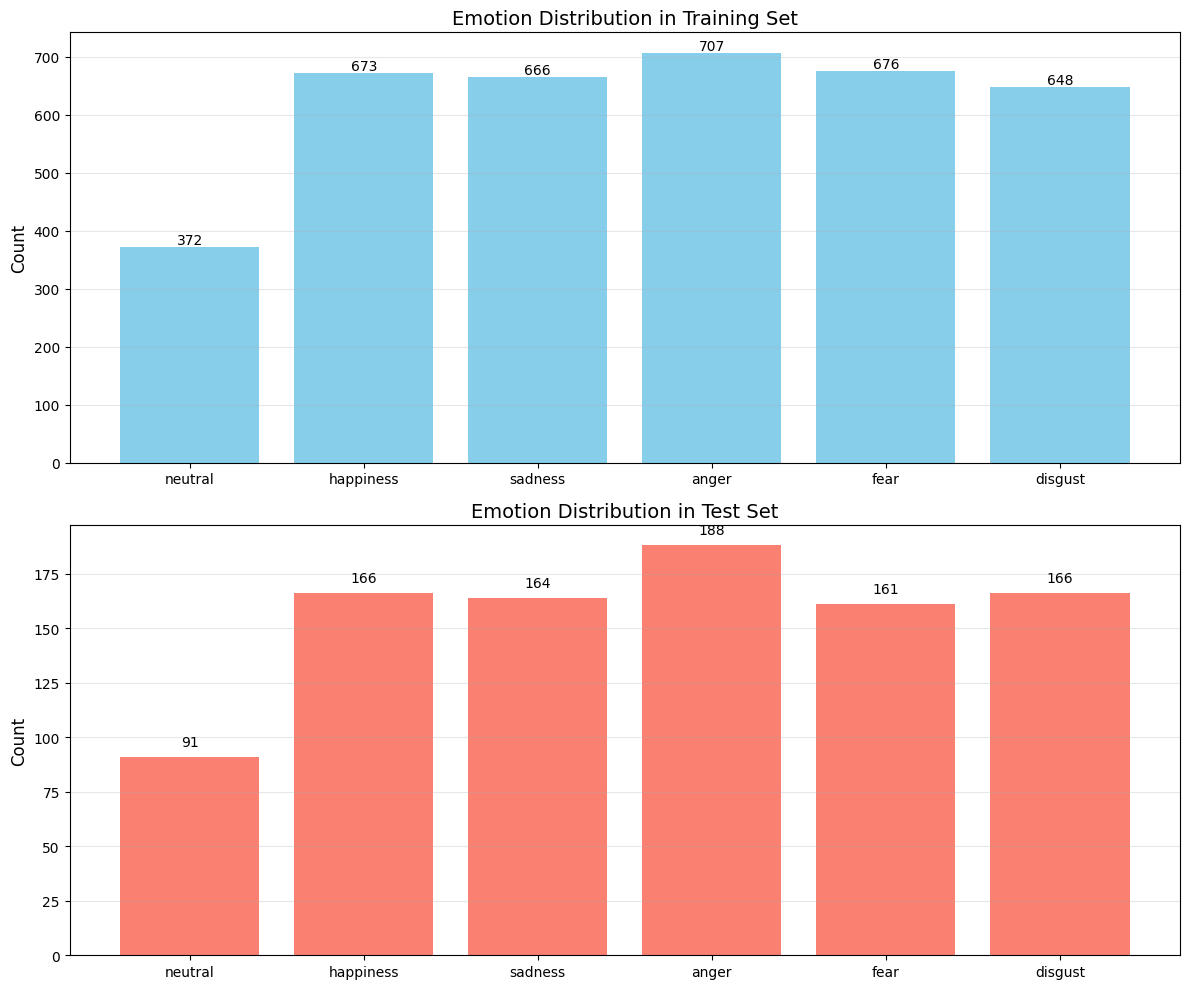

NameError: name 'SMALLER_MODEL' is not defined

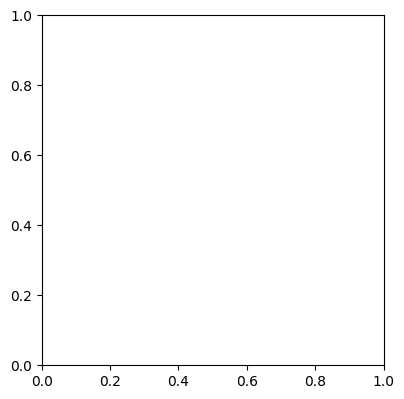

In [ ]:
visualize_dataset(train_ds, test_ds, emotions)


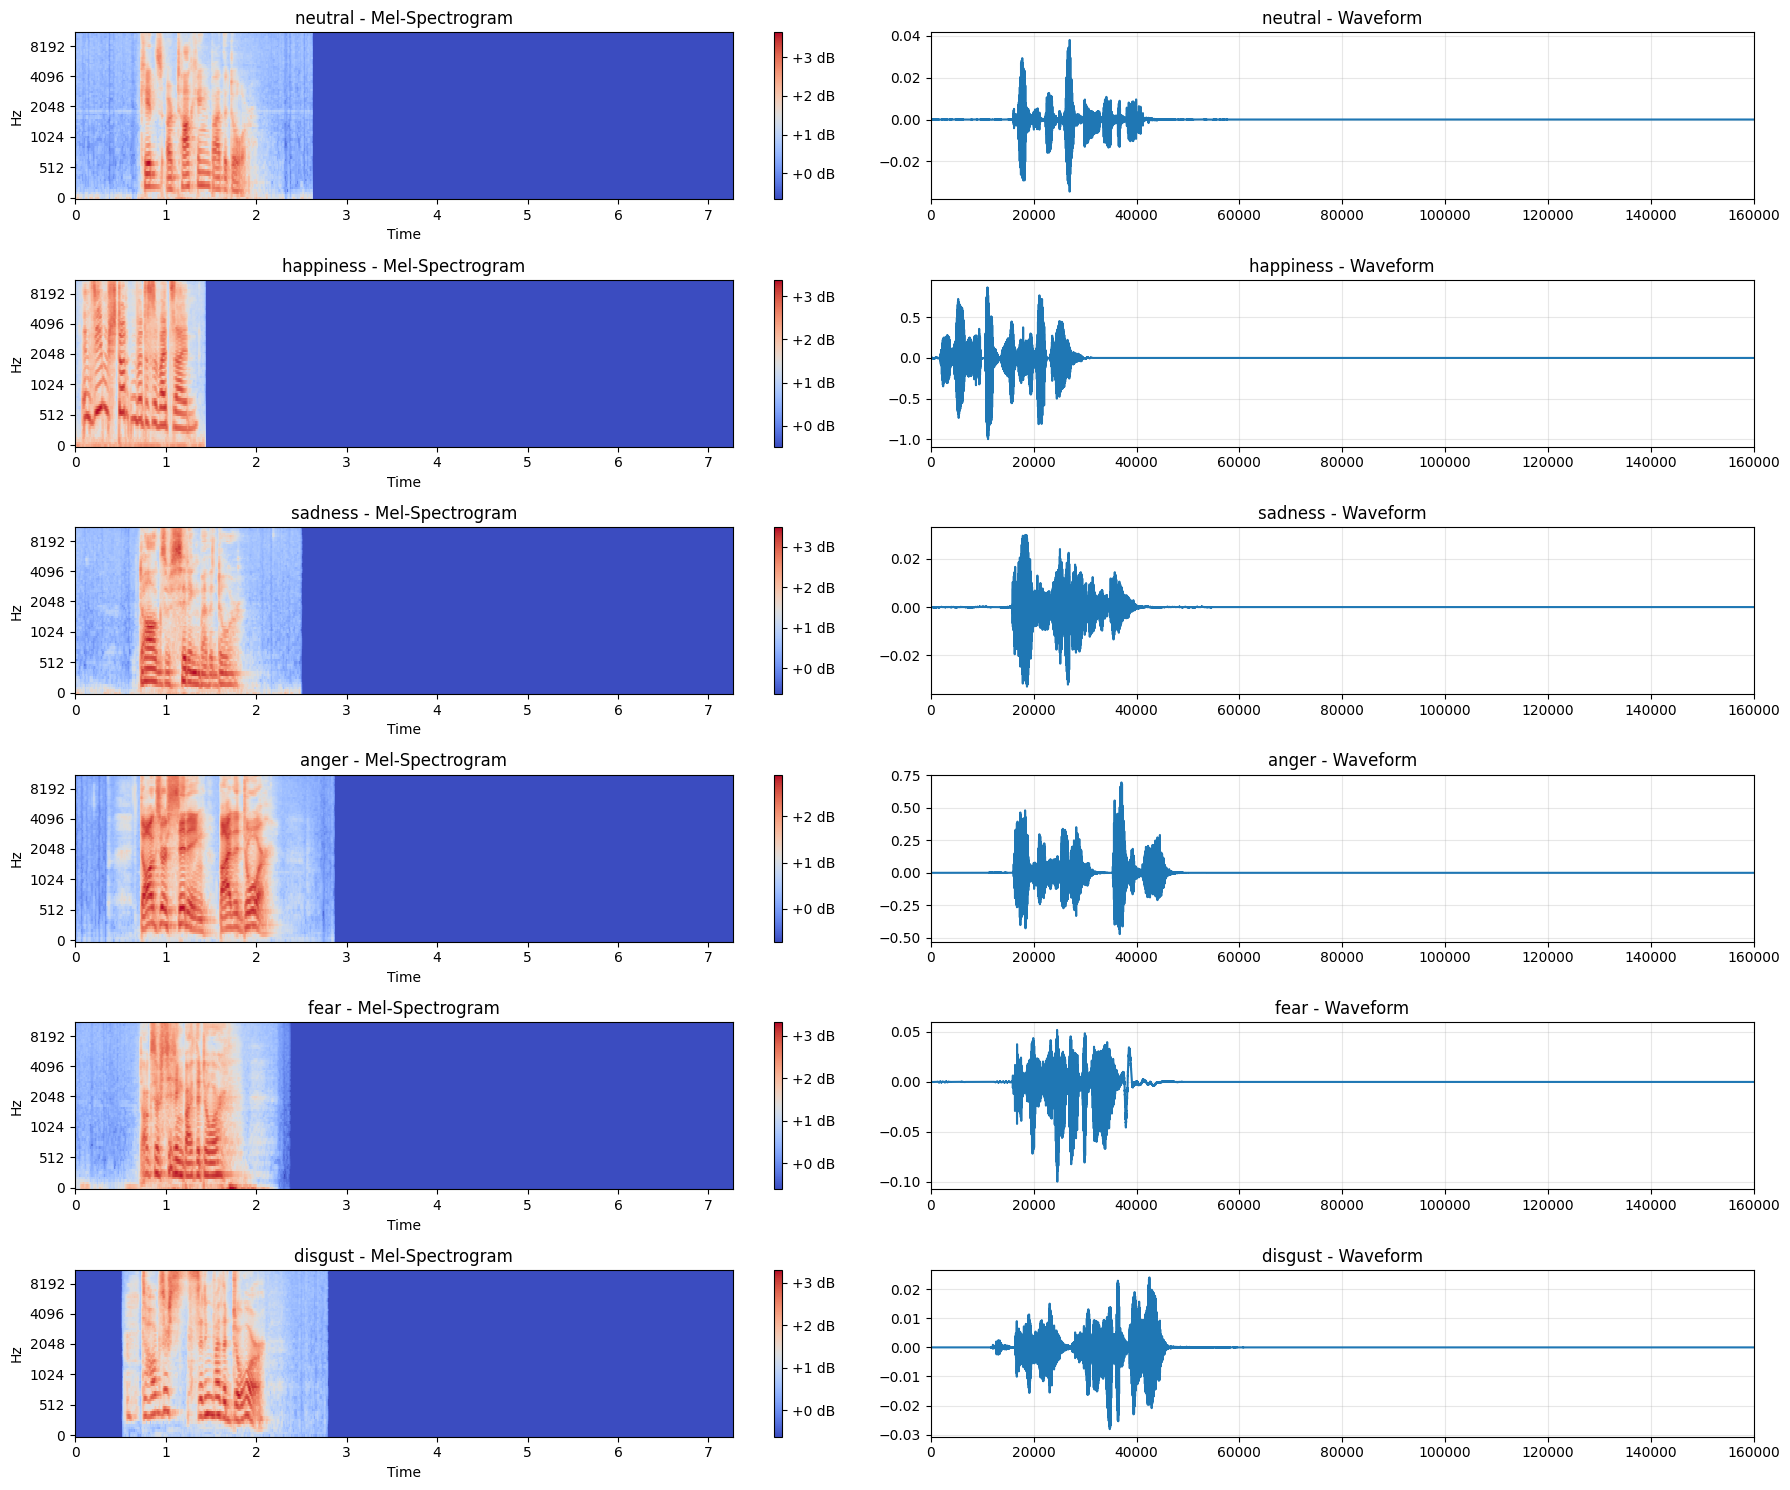


Audio samples for each emotion:

neutral audio sample:



happiness audio sample:



sadness audio sample:



anger audio sample:



fear audio sample:



disgust audio sample:


In [ ]:
visualize_emotion_spectrograms(
    train_ds,  # Your dataset
    emotions=["neutral", "happiness", "sadness", "anger", "fear", "disgust"],
    figsize=(18, 15)  # Adjust figure size as needed
)

In [ ]:
print("Available GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())


Available GPUs: 1
Current GPU: 0


## Training RESNET50 EmotionRecognitionModel

In [ ]:
# =========================================================
# Cell 10 : training runs
# =========================================================
ser = EmotionRecognitionModel(num_emotions=len(emotions))
train_ser(ser, train_loader, epochs=15)

[SER] ep   1/15  loss 1.4667  acc 40.005%


[SER] ep   2/15  loss 0.8659  acc 68.600%


[SER] ep   3/15  loss 0.5393  acc 81.480%


[SER] ep   4/15  loss 0.3210  acc 89.123%


[SER] ep   5/15  loss 0.2351  acc 91.849%


[SER] ep   6/15  loss 0.2026  acc 92.972%


[SER] ep   7/15  loss 0.1808  acc 93.747%


[SER] ep   8/15  loss 0.1558  acc 94.949%


[SER] ep   9/15  loss 0.0656  acc 98.129%


[SER] ep  10/15  loss 0.0893  acc 97.247%


[SER] ep  11/15  loss 0.1543  acc 94.816%


[SER] ep  12/15  loss 0.1372  acc 95.297%


[SER] ep  13/15  loss 0.1079  acc 96.232%


[SER] ep  14/15  loss 0.0856  acc 96.980%


[SER] ep  15/15  loss 0.0917  acc 96.766%


# 5. Evaluation ✅


🧪 Evaluating emotion recognition model...


Evaluating: 100%|██████████| 59/59 [00:30<00:00,  1.93it/s]


Accuracy : 0.9562
Precision: 0.9585
Recall   : 0.9562
F1‑score : 0.9566


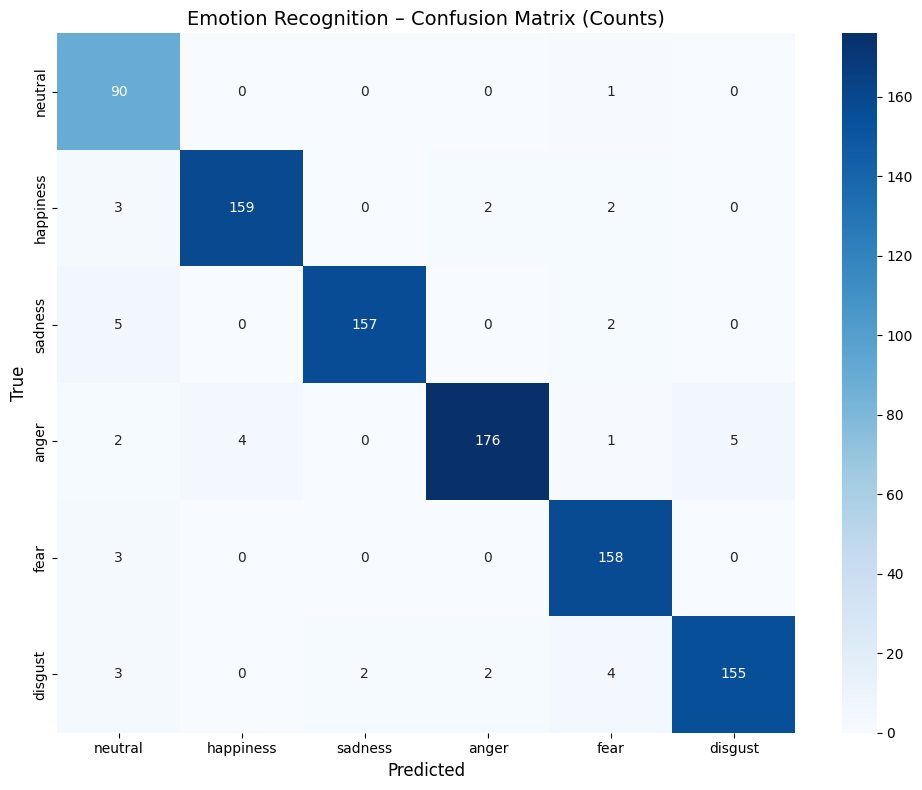

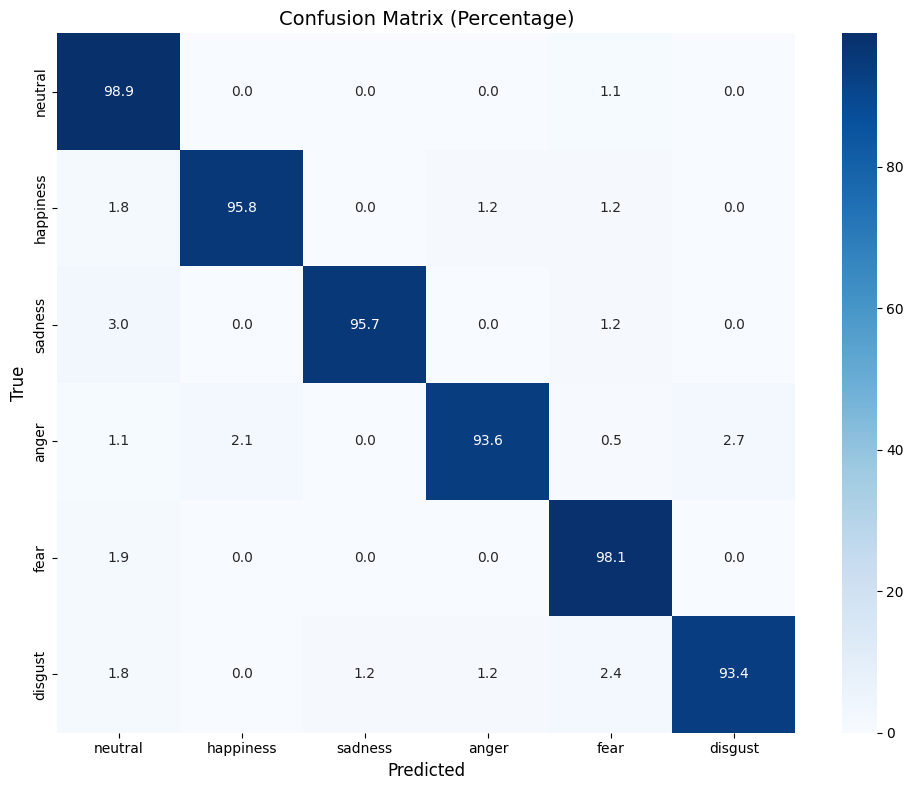

<Figure size 1200x600 with 0 Axes>

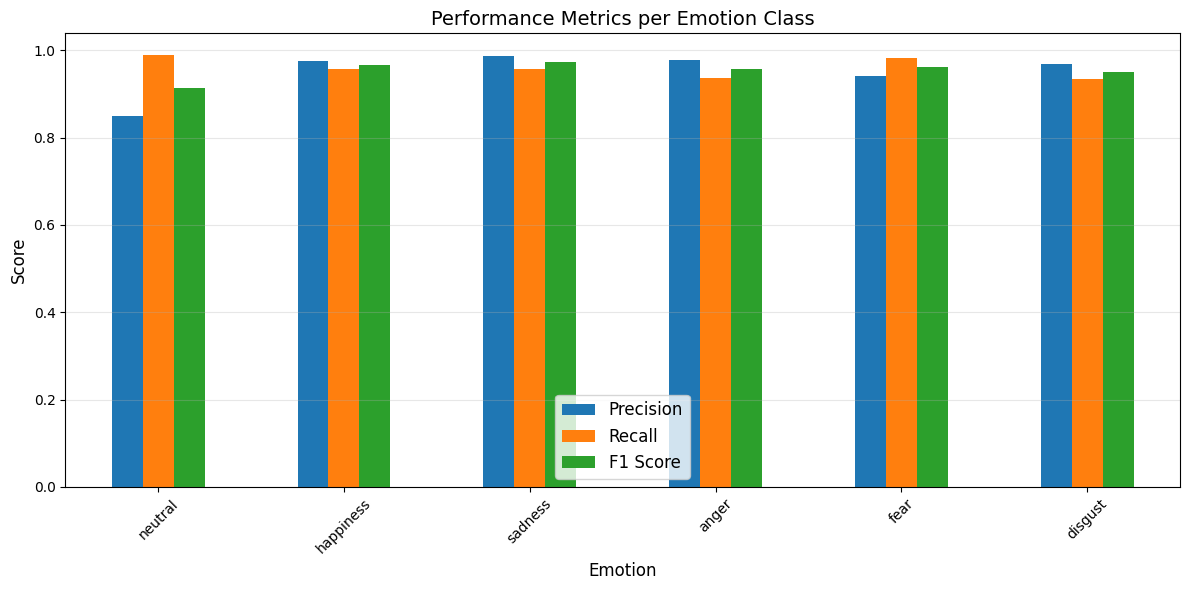

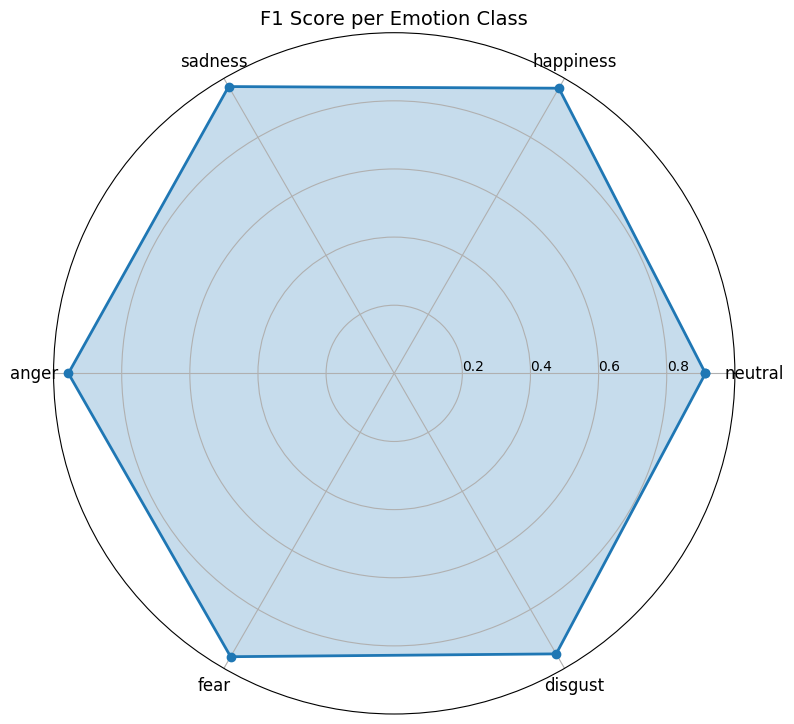

📊 Calculating prediction probabilities...


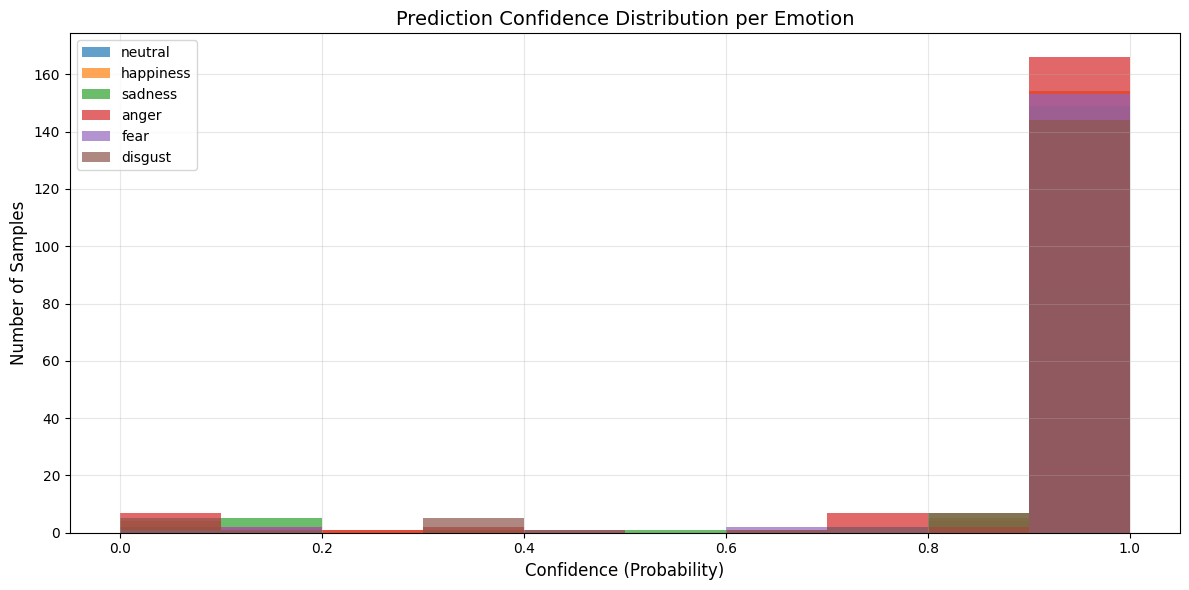

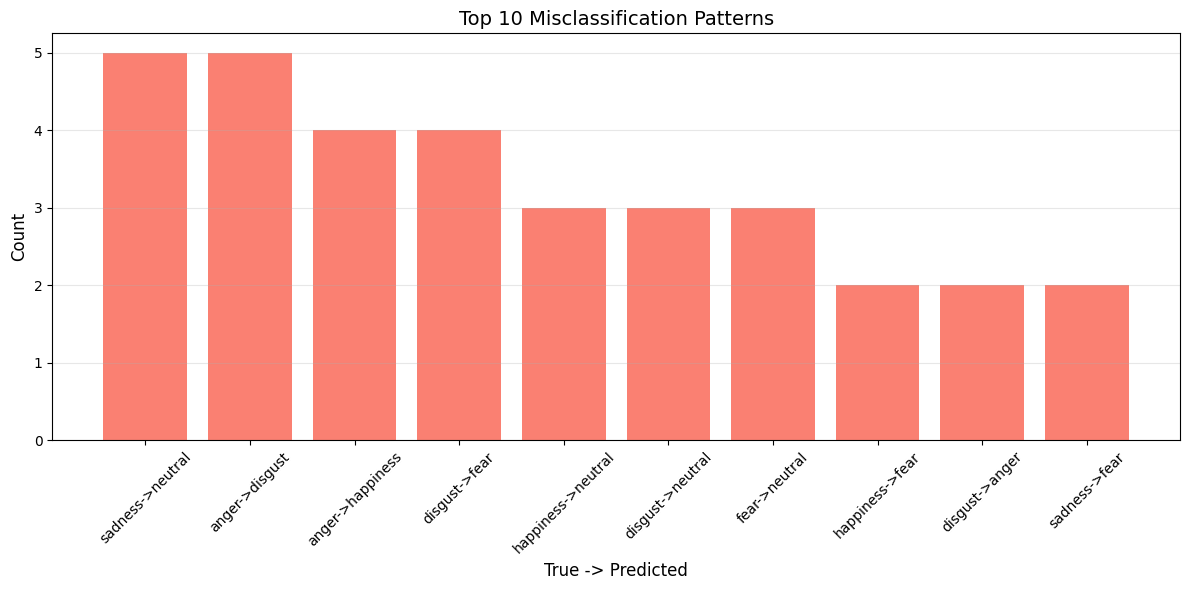

✅ Evaluation complete with enhanced visualizations!


In [ ]:
# ===== Cell 6: Evaluate emotion recogniser with enhanced visualizations =====
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

print("🧪 Evaluating emotion recognition model...")
emotion_eval = evaluate_emotion_recognition(
    model=ser,
    dataloader=test_loader,
    device=device,
)

print(f"Accuracy : {emotion_eval['accuracy']:.4f}")
print(f"Precision: {emotion_eval['precision']:.4f}")
print(f"Recall   : {emotion_eval['recall']:.4f}")
print(f"F1‑score : {emotion_eval['f1']:.4f}")

# 1. ENHANCED CONFUSION MATRIX
# Set up a larger figure for better visibility
plt.figure(figsize=(10, 8))

# Create a confusion matrix as a percentage of true labels
cm = emotion_eval['confusion_matrix']
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Generate the heatmap with both counts and percentages
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=emotions, yticklabels=emotions
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Emotion Recognition – Confusion Matrix (Counts)', fontsize=14)
plt.tight_layout()
plt.show()

# Percentage version
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_percentage, annot=True, fmt='.1f', cmap='Blues',
    xticklabels=emotions, yticklabels=emotions
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix (Percentage)', fontsize=14)
plt.tight_layout()
plt.show()

# 2. PER-CLASS METRICS VISUALIZATION
# Calculate per-class precision, recall, and F1
from sklearn.metrics import precision_recall_fscore_support

# Extract the true labels and predictions
y_true = emotion_eval['labels']
y_pred = emotion_eval['predictions']

# Calculate metrics per class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=range(len(emotions))
)

# Create a DataFrame for easier visualization
import pandas as pd
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Support': support
}, index=emotions)

# Plot the per-class metrics
plt.figure(figsize=(12, 6))
metrics_df[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(12, 6))
plt.title('Performance Metrics per Emotion Class', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Emotion', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. RADAR CHART FOR EMOTION RECOGNITION PERFORMANCE
# Prepare the radar chart
def radar_chart(categories, values, title):
    # Number of variables
    N = len(categories)

    # What will be the angle of each axis in the plot (divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Values to complete the loop
    values = np.concatenate((values, [values[0]]))

    # Initialize the figure
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)

    # Draw one axis per variable + add labels
    plt.xticks(angles[:-1], categories, fontsize=12)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], fontsize=10)
    plt.ylim(0, 1)

    # Plot data
    ax.plot(angles, values, 'o-', linewidth=2)

    # Fill area
    ax.fill(angles, values, alpha=0.25)

    # Add title
    plt.title(title, size=14)

    # Show the graph
    plt.tight_layout()
    plt.show()

# Create radar chart for F1 scores
radar_chart(
    categories=emotions,
    values=f1,
    title='F1 Score per Emotion Class'
)

# 4. PREDICTION CONFIDENCE VISUALIZATION
# This would require the softmax outputs from the model, which we don't have directly
# Let's add a function to get prediction probabilities for the test set

def get_prediction_probabilities(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['mel_spectrogram'].to(device)
            labels = batch['emotion']

            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_probs), np.array(all_labels)

# Get prediction probabilities
print("📊 Calculating prediction probabilities...")
probs, labels = get_prediction_probabilities(ser, test_loader, device)

# Visualize prediction confidence distribution
plt.figure(figsize=(12, 6))
for i, emotion in enumerate(emotions):
    # Get samples of this class
    indices = np.where(labels == i)[0]
    if len(indices) > 0:
        # Get the predicted probability for the correct class
        confidence = probs[indices, i]
        plt.hist(confidence, alpha=0.7, label=emotion, bins=10, range=(0, 1))

plt.title('Prediction Confidence Distribution per Emotion', fontsize=14)
plt.xlabel('Confidence (Probability)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. MISCLASSIFICATION ANALYSIS
# Find the top misclassified samples
misclassified = np.where(np.array(y_pred) != np.array(y_true))[0]
misclassification_count = {}

for i in misclassified:
    true_label = emotions[y_true[i]]
    pred_label = emotions[y_pred[i]]
    pair = (true_label, pred_label)
    misclassification_count[pair] = misclassification_count.get(pair, 0) + 1

# Sort by count
sorted_misclassifications = sorted(
    misclassification_count.items(),
    key=lambda x: x[1],
    reverse=True
)

# Visualize the top misclassifications
plt.figure(figsize=(12, 6))
pairs = [f"{true}->{pred}" for (true, pred), _ in sorted_misclassifications[:10]]
counts = [count for _, count in sorted_misclassifications[:10]]

plt.bar(pairs, counts, color='salmon')
plt.title('Top 10 Misclassification Patterns', fontsize=14)
plt.xlabel('True -> Predicted', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Evaluation complete with enhanced visualizations!")

# Training Diffusion Model

In [ ]:
# Assuming you have already defined your model, SER model, and data loader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
diff_net = DiffusionModel().to(DEVICE)

# Initialize sampler
sampler = DiffusionSampler(diff_net, ser, timesteps=200).to(DEVICE)

# Train diffusion model
train_diffusion(
    model=diff_net,
    sampler=sampler,
    emotion_model=ser,  # SER frozen
    dataloader=train_loader,
    epochs=10,
    lr=1e-4,
    save_dir="./checkpoints_diffusion",
    log_dir="./runs/diffusion",
    device=DEVICE,
    checkpoint_every=5,
    early_stop_patience=5,
)

Epoch 1/10: 100%|██████████| 234/234 [14:46<00:00,  3.79s/it, loss=0.116]


New best model saved with loss: 0.116237


Epoch 2/10: 100%|██████████| 234/234 [14:16<00:00,  3.66s/it, loss=0.0477]


New best model saved with loss: 0.047718


Epoch 3/10: 100%|██████████| 234/234 [14:16<00:00,  3.66s/it, loss=0.0444]


New best model saved with loss: 0.044357


Epoch 4/10: 100%|██████████| 234/234 [14:13<00:00,  3.65s/it, loss=0.0407]


New best model saved with loss: 0.040695


Epoch 5/10: 100%|██████████| 234/234 [14:15<00:00,  3.65s/it, loss=0.0405]


Checkpoint saved to ./checkpoints_diffusion/diffusion_model_epoch_5.pt
New best model saved with loss: 0.040490


Epoch 6/10: 100%|██████████| 234/234 [14:15<00:00,  3.66s/it, loss=0.0393]


New best model saved with loss: 0.039313


Epoch 9/10: 100%|██████████| 234/234 [14:15<00:00,  3.66s/it, loss=0.0376]


New best model saved with loss: 0.037619


Epoch 10/10: 100%|██████████| 234/234 [14:17<00:00,  3.67s/it, loss=0.0381]


Checkpoint saved to ./checkpoints_diffusion/diffusion_model_epoch_10.pt
Training completed. Best loss: 0.037619


## EVALUATION inspect a single enhanced mel

Target emotion: happiness


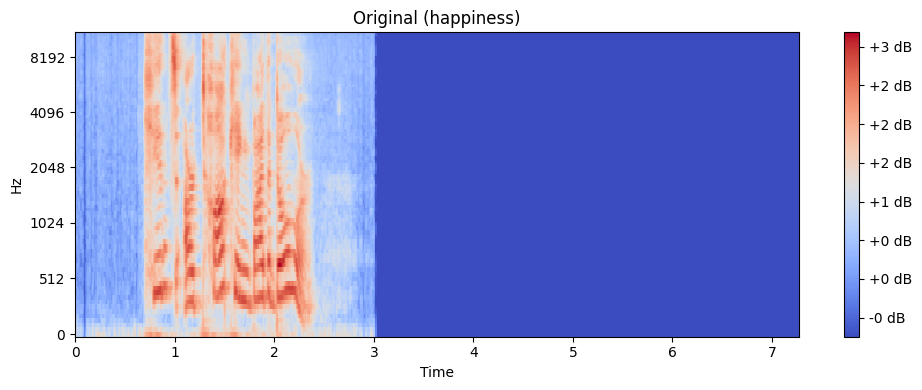

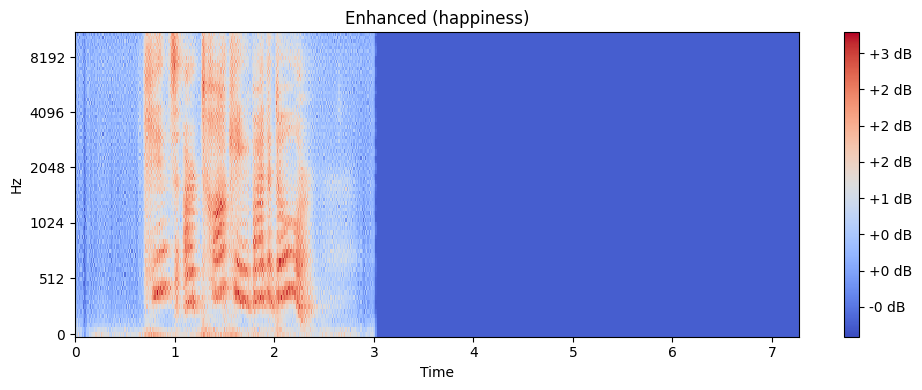

Play audio …


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# =========================================================
# Cell 11 : inspect a single enhanced mel  (fixed Audio calls)
# =========================================================
batch = next(iter(test_loader))
mel   = batch['mel_spectrogram'][0].to(DEVICE)
idx   = batch['emotion'][0].item()
print("Target emotion:", emotions[idx])

# run enhancement
enh   = sampler.enhance_emotion(mel, idx, steps=20)

# plot original vs enhanced
plot_mel(mel.cpu(),  f"Original ({emotions[idx]})")
plot_mel(enh,        f"Enhanced ({emotions[idx]})")

# play audio with explicit rate
print("Play audio …")
orig_audio = librosa.feature.inverse.mel_to_audio(
    mel.squeeze().cpu().numpy(), sr=SR, hop_length=HOP
)
enh_audio  = librosa.feature.inverse.mel_to_audio(
    enh.squeeze().numpy(), sr=SR, hop_length=HOP
)
display(Audio(orig_audio, rate=SR))a
display(Audio(enh_audio,  rate=SR))



## Evaluate performances using loss and accuracy.


✨ Enhancing subset...


100%|██████████| 10/10 [01:39<00:00,  9.90s/it]



🧪 Original subset evaluation …

🧪 Enhanced subset evaluation …

✅ Accuracy  – original: 1.0000  |  enhanced: 0.6000
✅ F1-score – original: 1.0000  |  enhanced: 0.5040


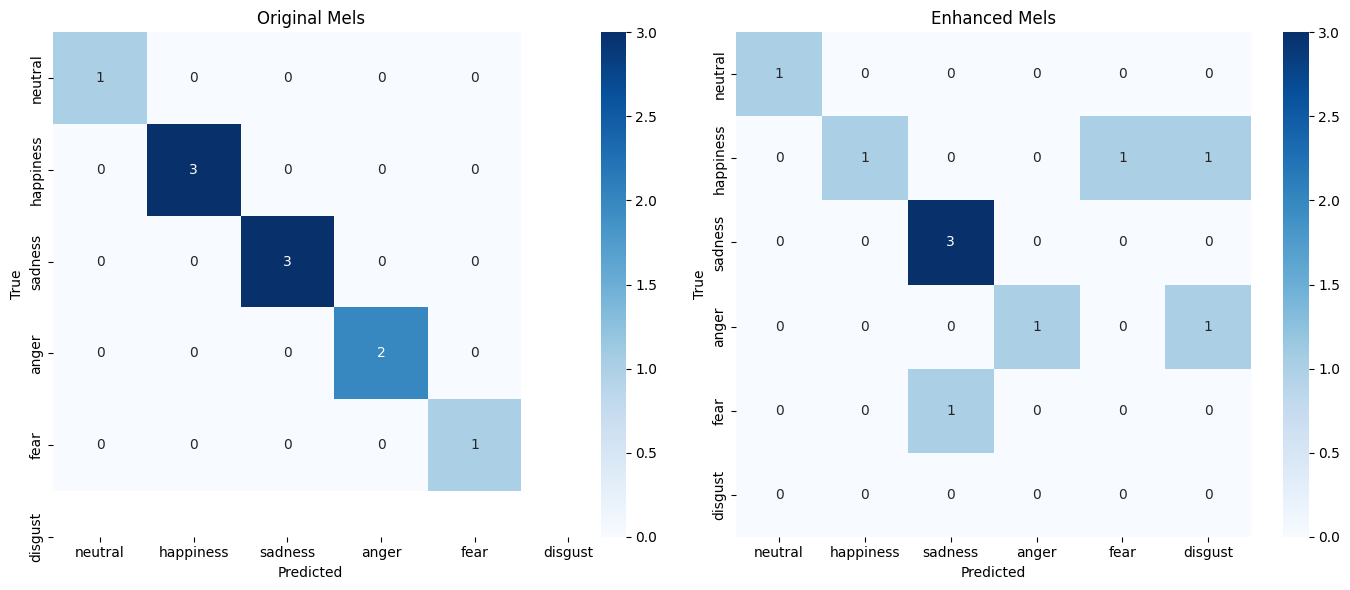

In [ ]:
# =========================================================
# Cell 12: Enhance test subset & evaluate performance
# =========================================================
test_dataset = test_ds  # Alias for clarity in later cells

# --- Subset to enhance (e.g., 100 samples to save memory)
subset_size = min(10, len(test_dataset))
subset_idxs = list(range(subset_size))
test_subset = torch.utils.data.Subset(test_dataset, subset_idxs)

# --- Enhance all subset samples with diffusion model
enhanced_mels, enhanced_labels = [], []

print("✨ Enhancing subset...")
for sample in tqdm(test_subset):
    mel   = sample['mel_spectrogram'].to(DEVICE)
    label = sample['emotion']
    with torch.no_grad():
        enhanced = sampler.enhance_emotion(mel, label, steps=50)
    enhanced_mels.append(enhanced.cpu())
    enhanced_labels.append(label)
    torch.cuda.empty_cache()

# --- Wrap into dataset
class EnhancedDataset(Dataset):
    def __init__(self, mels, labels):
        self.mels   = mels
        self.labels = labels
    def __len__(self): return len(self.mels)
    def __getitem__(self, idx):
        return {
            'mel_spectrogram': self.mels[idx].unsqueeze(0),  # add channel dim
            'emotion': self.labels[idx]
        }

enh_dataset     = EnhancedDataset(enhanced_mels, enhanced_labels)
enh_dataloader  = DataLoader(enh_dataset, batch_size=1, shuffle=False, num_workers=0)
subset_loader   = DataLoader(test_subset, batch_size=1, shuffle=False, num_workers=0)

# --- Evaluation function
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def evaluate_emotion_recognition(model, loader, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            mel = batch['mel_spectrogram'].to(device)

            # Ensure shape is [batch, channels, height, width]
            if mel.dim() == 3:         # [channels, height, width]
                mel = mel.unsqueeze(0)
            elif mel.dim() == 5:       # [1, 1, 1, 80, 861] → remove extra dim
                mel = mel.squeeze(1)
            elif mel.dim() != 4:
                raise ValueError(f"Unexpected input shape: {mel.shape}")
            lab = batch['emotion'].to(device)
            out = model(mel)
            pred = out.argmax(1)
            preds.extend(pred.cpu().numpy())
            trues.extend(lab.cpu().numpy())
    acc = accuracy_score(trues, preds)
    f1  = f1_score(trues, preds, average='macro')
    cm  = confusion_matrix(trues, preds)
    return {'accuracy': acc, 'f1': f1, 'confusion_matrix': cm}

# --- Compare original vs enhanced
print("\n🧪 Original subset evaluation …")
orig_metrics = evaluate_emotion_recognition(ser, subset_loader, device=DEVICE)

print("\n🧪 Enhanced subset evaluation …")
enh_metrics = evaluate_emotion_recognition(ser, enh_dataloader, device=DEVICE)

# --- Report results
print(f"\n✅ Accuracy  – original: {orig_metrics['accuracy']:.4f}  |  enhanced: {enh_metrics['accuracy']:.4f}")
print(f"✅ F1-score – original: {orig_metrics['f1']:.4f}  |  enhanced: {enh_metrics['f1']:.4f}")

# --- Visualize confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(14,6))
for a, cm, title in zip(
    ax,
    [orig_metrics['confusion_matrix'], enh_metrics['confusion_matrix']],
    ['Original Mels', 'Enhanced Mels']):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions, yticklabels=emotions, ax=a)
    a.set_xlabel('Predicted'); a.set_ylabel('True'); a.set_title(title)
plt.tight_layout(); plt.show()
